# Восстановление золота из руды

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.



**Технологический процесс:
<br>Rougher feed — исходное сырье
<br>Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
<br>Xanthate **— ксантогенат (промотер, или активатор флотации);
<br>Sulphate — сульфат (на данном производстве сульфид натрия);
<br>Depressant — депрессант (силикат натрия).
<br>Rougher process (англ. «грубый процесс») — флотация
<br>Rougher tails — отвальные хвосты
<br>Float banks — флотационная установка
<br>Cleaner process — очистка
<br>Rougher Au — черновой концентрат золота
<br>Final Au — финальный концентрат золота
<br><br>Параметры этапов:
<br>air amount — объём воздуха
<br>fluid levels — уровень жидкости
<br>feed size — размер гранул сырья
<br>feed rate — скорость подачи**

**Наименование признаков:
<br>Наименование признаков должно быть такое:
<br>[этап].[тип_параметра].[название_параметра]
<br>Пример: rougher.input.feed_ag
<br>Возможные значения для блока [этап]:
<br>rougher — флотация
<br>primary_cleaner — первичная очистка
<br>secondary_cleaner — вторичная очистка
<br>final — финальные характеристики
<br><br>Возможные значения для блока [тип_параметра]:
<br>input — параметры сырья
<br>output — параметры продукта
<br>state — параметры, характеризующие текущее состояние этапа
<br>calculation — расчётные характеристики**

In [1]:
# подключаем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer

## Подготовка данных

In [2]:
# считваем файлы
try:
    full = pd.read_csv('/datasets/gold_recovery_full_new.csv')
    train = pd.read_csv('/datasets/gold_recovery_train_new.csv')
    test = pd.read_csv('/datasets/gold_recovery_test_new.csv')
except:
    full = pd.read_csv('gold_recovery_full_new.csv')
    train = pd.read_csv('gold_recovery_train_new.csv')
    test = pd.read_csv('gold_recovery_test_new.csv')

In [3]:
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

*Видим небольшое количество пустых значений, от них мы избавимся*

### Эффективность обогащения

In [6]:
# выделем переменные для посчета эффективности и очистим от пустот
train.dropna(subset=['rougher.output.concentrate_au', 'rougher.input.feed_au',
                                   'rougher.output.tail_au','rougher.output.recovery'], inplace=True)
concentrate_au = train['rougher.output.concentrate_au']
feed_au = train['rougher.input.feed_au']
tail_au = train['rougher.output.tail_au']
recovery = train['rougher.output.recovery']

In [7]:
# смотрим по формуле эффективность обогащения
recovery_solve = (concentrate_au * (feed_au - tail_au) / feed_au / (concentrate_au - tail_au) * 100)
print(f'Эффективность обогащения:\n{recovery_solve}')
print('~'*50)
print(f'\nMAE: {mean_absolute_error(recovery, recovery_solve)}')

Эффективность обогащения:
0        87.107763
1        86.843261
2        86.842308
3        87.226430
4        86.688794
           ...    
14144    89.574376
14145    87.724007
14146    88.890579
14147    89.858126
14148    89.514960
Length: 14149, dtype: float64
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

MAE: 1.0748911125799084e-14


**Средне абсолютное отклонение очень маленькое, которое говорит о том, что значение rougher.output.recovery расчитано правильно**

### Разница выборок

In [8]:
# смотрим на разницу индексов
set(train.columns) - set(test.columns)

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

**Смотрим на разницу, видим output, что говорит о том, что это целевые переменные
<br>И calculation, который видимо считается в процессе**

### Предобработка данных

In [9]:
# удалим пустоты
full = full.dropna()
train = train.dropna()
test = test.dropna();

In [10]:
# время особо не нужно, сделаем индексами
full = full.set_index('date')
train = train.set_index('date')
test = test.set_index('date')

In [11]:
# порежем точность
full = full.loc[:,'final.output.concentrate_ag':].apply(np.float32)
train = train.loc[:,'final.output.concentrate_ag':].apply(np.float32)
test = test.loc[:,'primary_cleaner.input.sulfate':].apply(np.float32)

In [12]:
# распределим данные
y = test
X_rougher = train[[i for i in test.columns if 'rougher' in i]]
X = train[[i for i in test.columns]]

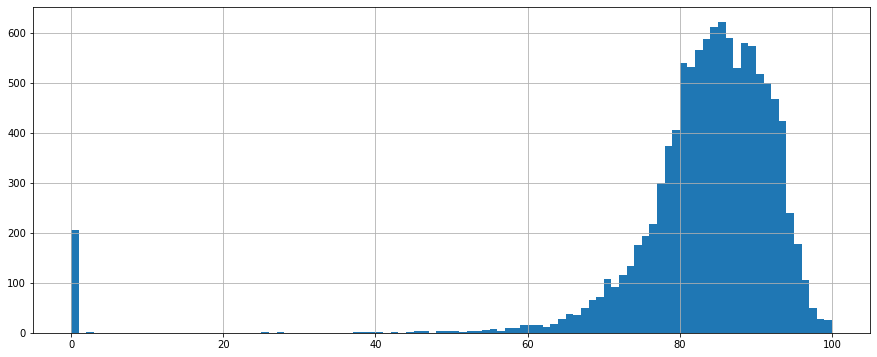

In [13]:
# потсмотрим на распределение
train['rougher.output.recovery'].hist(figsize=(15,6), bins=100);

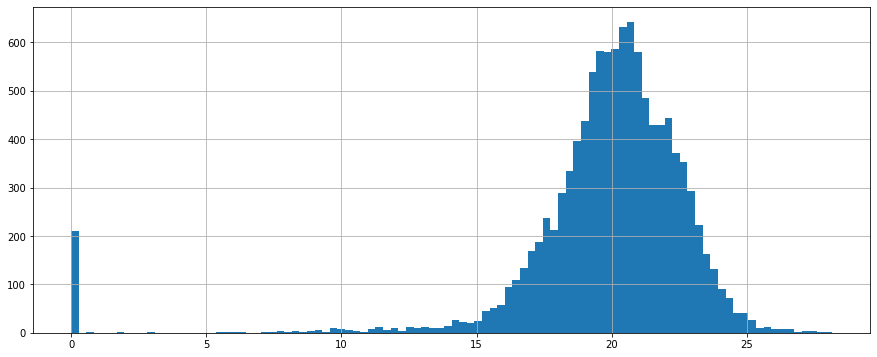

In [14]:
# потсмотрим на распределение
train['rougher.output.concentrate_au'].hist(figsize=(15,6), bins=100);

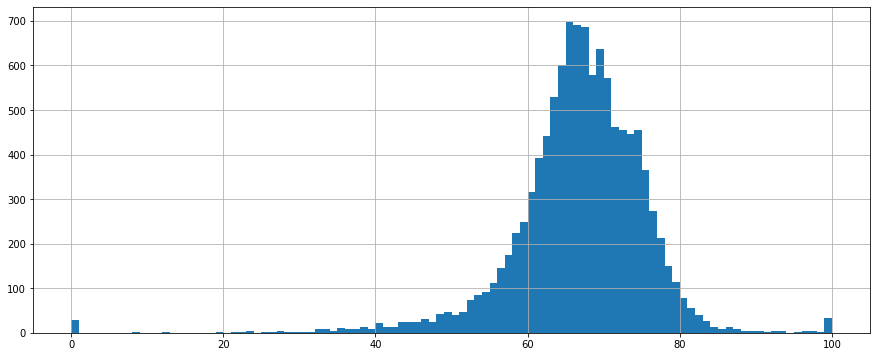

In [15]:
# потсмотрим на распределение
train['final.output.recovery'].hist(figsize=(15,6), bins=100);

In [16]:
# видно, что присутствуют нули в данных, очистим
train = train.drop(train[train['rougher.output.recovery'] == 0].index)
train = train.drop(train[train['final.output.recovery'] == 0].index)
train = train.drop(train[train['rougher.output.concentrate_au'] == 0].index)

**Исходя из данных было обнаружено, что в тестовых данных нет признаков, которые высчитываются в процесе, а так же отсутствуют целевые признаки
<br>Так же в данных присутствуют пропущенные значения, их достаточно мало, из-за чего было принято решение от них избавиться
<br>Понизил точность до одинарной, поскольку данной точноти будет достаточно
<br>И в конце по графикам было замечено, что в данных имеются нули, от которых тоже избавляемся**

## Анализ данных

### Изменение концентрация металлов (Au, Ag, Pb) на различных этапах очистки

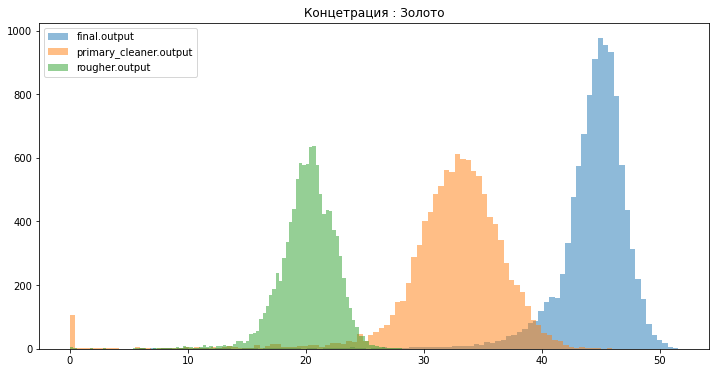

In [17]:
# Золото
plt.figure(figsize=(12,6))
plt.hist(train['final.output.concentrate_au'], bins=100, label = 'final.output', alpha=.5)
plt.hist(train['primary_cleaner.output.concentrate_au'], bins=100, label = 'primary_cleaner.output', alpha=.5)
plt.hist(train['rougher.output.concentrate_au'], bins=100, label = 'rougher.output', alpha=.5)
plt.title("Концетрация : Золото")
plt.legend();

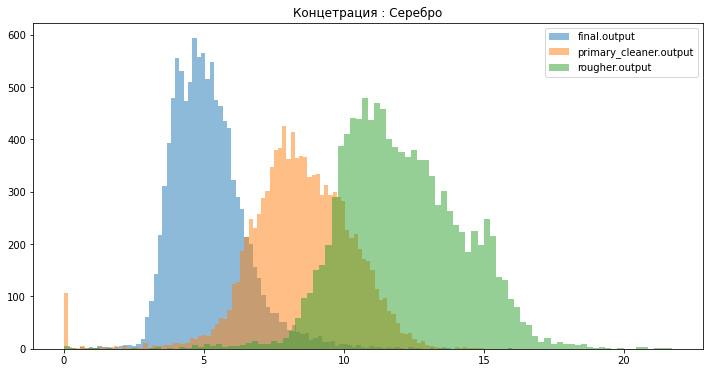

In [18]:
# Серебро
plt.figure(figsize=(12,6))
plt.hist(train['final.output.concentrate_ag'], bins=100, label = 'final.output', alpha=.5)
plt.hist(train['primary_cleaner.output.concentrate_ag'], bins=100, label = 'primary_cleaner.output', alpha=.5)
plt.hist(train['rougher.output.concentrate_ag'], bins=100, label = 'rougher.output', alpha=.5)
plt.title("Концетрация : Серебро")
plt.legend();

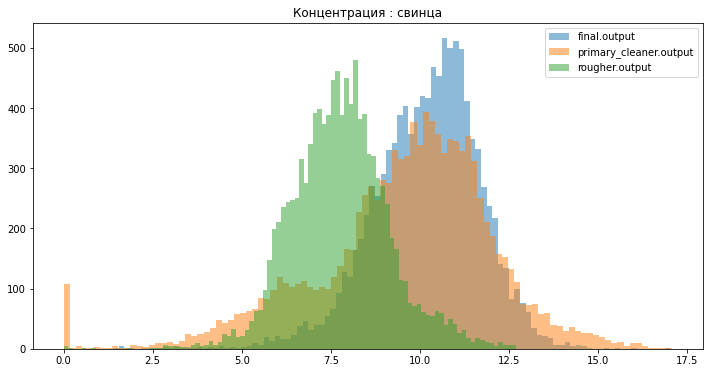

In [19]:
# Свинец
plt.figure(figsize=(12,6))
plt.hist(train['final.output.concentrate_pb'], bins=100, label = 'final.output', alpha=.5)
plt.hist(train['primary_cleaner.output.concentrate_pb'], bins=100, label = 'primary_cleaner.output', alpha=.5)
plt.hist(train['rougher.output.concentrate_pb'], bins=100, label = 'rougher.output', alpha=.5)
plt.title("Концентрация : свинца")
plt.legend();

**Рассмотрев графики можно увидеть, что концетрация золота растет**

### Распределения размеров гранул сырья на обучающей и тестовой выборках

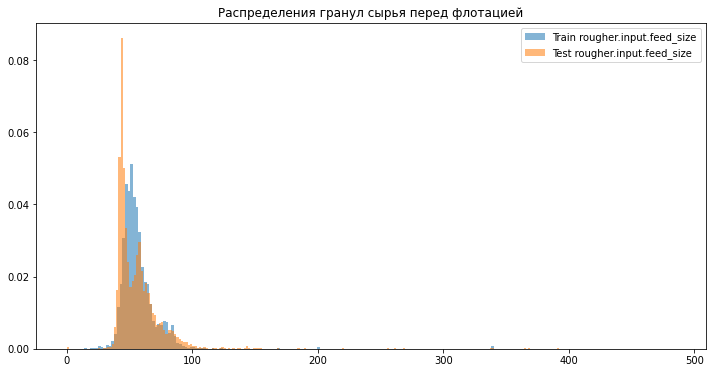

In [20]:
# Перед флотацией
plt.figure(figsize=(12,6))
plt.hist(train['rougher.input.feed_size'], bins=220, label = 'Train rougher.input.feed_size', alpha=.55, density=True)
plt.hist(test['rougher.input.feed_size'], bins=220, label = 'Test rougher.input.feed_size', alpha=.55, density=True)
plt.title("Распределения гранул сырья перед флотацией")
plt.legend();

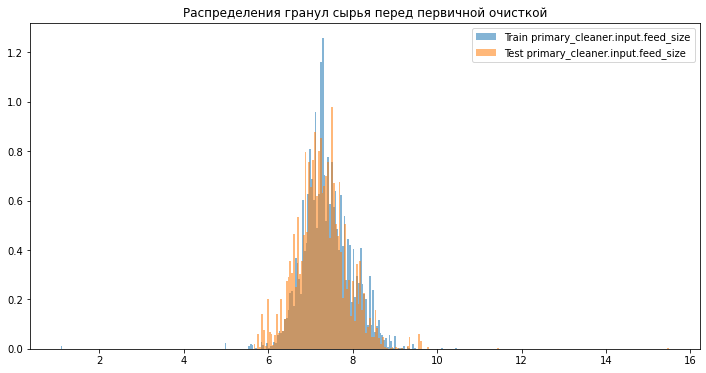

In [21]:
# Перед первичной очисткой
plt.figure(figsize=(12,6))
plt.hist(train['primary_cleaner.input.feed_size'], bins=220, label = 'Train primary_cleaner.input.feed_size', alpha=.55, density=True)
plt.hist(test['primary_cleaner.input.feed_size'], bins=220, label = 'Test primary_cleaner.input.feed_size', alpha=.55, density=True)
plt.title("Распределения гранул сырья перед первичной очисткой")
plt.legend();

**Распределение выглядит нормально
<br>Так же отметим сходство графиков, которое говорит, что оценка моделей будет правильной**

### Суммарная концентрацию всех веществ на разных стадиях

In [22]:
# посчитаем суммы на всех этапах
final_concentrate_sum = train[['final.output.concentrate_au','final.output.concentrate_ag','final.output.concentrate_pb','final.output.concentrate_sol']].sum(axis=1)
rougher_feed_concentrate_sum = train[['rougher.input.feed_au', 'rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.feed_sol']].sum(axis=1)
rougher_concentrate_sum = train[['rougher.output.concentrate_au', 'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol']].sum(axis=1)

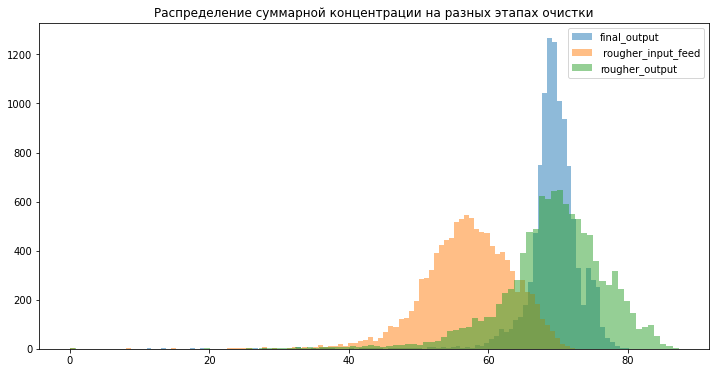

In [23]:
#  Суммарная концентрация
plt.figure(figsize=(12,6))
plt.hist(final_concentrate_sum, bins=100,  label = 'final_output', alpha=.5)
plt.hist(rougher_feed_concentrate_sum,bins=100,  label = ' rougher_input_feed', alpha=.5)
plt.hist(rougher_concentrate_sum, bins=100, label = 'rougher_output', alpha=.5)
plt.title("Распределение суммарной концентрации на разных этапах очистки")
plt.legend();

In [24]:
# частенько нули, убираем
train = train.drop(train[train['primary_cleaner.output.concentrate_au'] == 0].index)

## Модель

### Функция для вычисления итоговой sMAPE

In [25]:
def sMAPE(y_true,y_pred):
    return np.mean(abs(y_true - y_pred)/((abs(y_true)+abs(y_pred))/2))*100

In [26]:
def final_sMAPE(sMAPE_rougher,sMAPE_final):
    return (0.25*sMAPE_rougher + 0.75*sMAPE_final)

### Обучение моделей

In [27]:
# получим обучающую выборку 
del_frame = set(train.columns) - set(y.columns)
X_train_final = train.drop(del_frame, axis=1)
del_frame_2 = set(X_train_final.columns) - set(X_rougher.columns)
X_train_rougher = X_train_final.drop(del_frame_2, axis=1)
y_train_rougher = train['rougher.output.recovery']
y_train_final = train['final.output.recovery']
X_test_final = y
columns_to_delete = set(X_test_final.columns) - set(X_rougher.columns)
X_test_rougher = X_test_final.drop(columns_to_delete, axis=1)

In [28]:
# создадим параметры для поиска лучших гиперпараметров
params_rf = {"n_estimators": range(1,101),
             "max_depth": range(1,11)}
params_dt = {"max_depth": range(1,11)}

In [29]:
# создание собственного scoring
custom_score = make_scorer(sMAPE,greater_is_better=False)

In [30]:
# объявляем модели
grid_rougher_rf = RandomizedSearchCV(RandomForestRegressor(), params_rf, scoring=custom_score, cv=5)
grid_final_rf = RandomizedSearchCV(RandomForestRegressor() , params_rf, scoring=custom_score, cv=5)
grid_rougher_dt = RandomizedSearchCV(DecisionTreeRegressor() , params_dt, scoring=custom_score, cv=5)
grid_final_dt = RandomizedSearchCV(DecisionTreeRegressor(), params_dt, scoring=custom_score, cv=5)

In [31]:
# обучаем на трейновой выборке
grid_rougher_rf.fit(X_train_rougher, y_train_rougher)
grid_final_rf.fit(X_train_final, y_train_final)
grid_rougher_dt.fit(X_train_rougher, y_train_rougher)
grid_final_dt.fit(X_train_final, y_train_final)

RandomizedSearchCV(cv=5, estimator=DecisionTreeRegressor(),
                   param_distributions={'max_depth': range(1, 11)},
                   scoring=make_scorer(sMAPE, greater_is_better=False))

In [32]:
# смотрим на лучшие параметры
print(grid_rougher_rf.best_estimator_)
print(grid_final_rf.best_estimator_)
print(grid_rougher_dt.best_estimator_)
print(grid_final_dt.best_estimator_)

RandomForestRegressor(max_depth=6, n_estimators=68)
RandomForestRegressor(max_depth=1, n_estimators=44)
DecisionTreeRegressor(max_depth=2)
DecisionTreeRegressor(max_depth=1)


In [33]:
# сохраняем лучшие метрики
best_grid_rougher_rf = grid_rougher_rf.best_score_
best_grid_final_rf = grid_final_rf.best_score_
best_grid_rougher_dt = grid_rougher_dt.best_score_
best_grid_final_dt = grid_final_dt.best_score_

In [34]:
# Выводим результаты
print(f"rougher\nRandomForest {best_grid_rougher_rf}, DecisionTree {best_grid_rougher_dt}")
print(f"final\nRandomForest {best_grid_final_rf}, DecisionTree {best_grid_final_dt}")

rougher
RandomForest -6.014297650902321, DecisionTree -6.321272394151251
final
RandomForest -8.150235574922391, DecisionTree -8.211123515200565


In [35]:
final_sMAPE(best_grid_rougher_rf,best_grid_final_rf)

-7.6162510939173735

In [36]:
final_sMAPE(best_grid_rougher_dt,best_grid_final_dt)

-7.738660734938237

**Как видим, лучшие результаты показывает случайный лес**

**Пререходим к проверке на тестовой**

In [37]:
# собираем переменные в кучку
df_y_test = y.merge(full.loc[:,["rougher.output.recovery",
                                                           "final.output.recovery"]],
                                left_index=True, right_index=True)
y_test_rougher = df_y_test["rougher.output.recovery"]
y_test_final = df_y_test["final.output.recovery"]

In [38]:
# строим предсказания
rogher_test = grid_rougher_rf.predict(X_test_rougher.loc[y_test_rougher.index])
final_test = grid_final_rf.predict(X_test_final.loc[y_test_final.index])

In [39]:
# Итоговое sMAPE
final_sMAPE(sMAPE(y_test_rougher, rogher_test),sMAPE(y_test_final,final_test))

8.150186533982678

**Финальная ошибка на тестовой выборке 8,1**

**Построим константную модель**

In [40]:
dummy_regressor_rougher = DummyRegressor(strategy="median")
dummy_regressor_rougher.fit(X_test_rougher.loc[y_test_rougher.index],y_test_rougher)
dummy_rougher_pred = dummy_regressor_rougher.predict(rogher_test)
smape_dummy_rougher = sMAPE(y_test_rougher, dummy_rougher_pred)
smape_dummy_rougher 

7.73487463593483

In [41]:
dummy_regressor_final = DummyRegressor(strategy="median")
dummy_regressor_final.fit(X_test_final.loc[y_test_final.index],y_test_final)
dummy_final_pred = dummy_regressor_final.predict(final_test)
smape_dummy_final = sMAPE(y_test_final, dummy_final_pred)
smape_dummy_final

7.752420753240585

In [42]:
final = (smape_dummy_final + smape_dummy_rougher)/2
final

7.7436476945877075

**Ошибка на тесте 8.1, а на константной 7.7**

**Выводы:
<br>1) Перед нами оказались сырые данные, в которых к удивлению было не много пропусков от общего объема, но присутсвовало много нулей, от которых мы избавились. Так же уменьшили точность, поскольку нам хватает одинарной
<br>2) Посчитав эффективность обогощения, можно было сделать вывод, что она рассчитана правильно
<br>3) Проведя анализ на различных этапах очистки, можно заметить рост концетрации золота
<br>4) Распередения гранул не сильно отличалось, соответственно на результаты моделей можно рассчитывать
<br>5) Так же было исследованно суммарная концетрация, откуда избавились от нулей
<br>6) Написали собственную функцию для sMAPE
<br>7) Обучили модели, и где лучшие результаты показал случайный лес
<br>8) Протостировав на тестовых значениях, мы получили sMAPE в размере 8.5**